<a href="https://colab.research.google.com/github/manamendraJN/fashion-intelligence-platform/blob/feature%2Fbody-measurement-and-sizing/notebooks/body_measurement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cell 1 - Setup and Environment Configuration

In [1]:
# PURPOSE: Install required packages, import libraries, and configure the environment
# WHY: Sets up all dependencies needed for deep learning model training

import sys
from datetime import datetime, timezone

# Print session information for tracking
print(f"Student: manamendraJN | Date: {datetime.now(timezone. utc).strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Python:  {sys.version. split()[0]}")

# Install required packages silently (-q flag)
# timm: Pre-trained vision models library
# albumentations: Advanced image augmentation library
! pip install -q timm albumentations

# Core deep learning imports
import torch
import torch.nn as nn  # Neural network layers
import torch.optim as optim  # Optimizers (AdamW)
from torch.utils.data import Dataset, DataLoader  # Data loading utilities
import timm  # Pre-trained models (EfficientNet, ResNet, MobileNet)

# Data processing imports
import numpy as np  # Numerical operations
import pandas as pd  # CSV/dataframe handling
import cv2  # Image loading
from pathlib import Path  # File path operations
import json  # Save/load configuration files

# Image augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Utilities
from tqdm. auto import tqdm  # Progress bars
import matplotlib.pyplot as plt  # Plotting
import seaborn as sns  # Statistical visualizations
from sklearn.metrics import r2_score  # R² metric calculation

# Configure plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set device (GPU if available, else CPU)
# WHY: GPU is 10-100x faster for deep learning
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Print environment information
print(f"✅ PyTorch {torch.__version__} | Device: {device}")
if torch.cuda.is_available():
    print(f"✅ GPU:  {torch.cuda.get_device_name(0)} ({torch.cuda.get_device_properties(0).total_memory/1e9:.1f} GB)")
print("🎲 Running without fixed seeds (non-deterministic mode)")
# NOTE: No random seeds = different results each run (but more realistic generalization)

Student: manamendraJN | Date: 2025-12-12 04:45:36
Python:  3.12.12
✅ PyTorch 2.9.0+cu126 | Device: cuda
✅ GPU:  Tesla T4 (15.8 GB)
🎲 Running without fixed seeds (non-deterministic mode)


# Cell 2 - Google Drive Integration and Directory Setup

In [2]:
# PURPOSE: Mount Google Drive and create project directory structure
# WHY:  Persist data/models across Colab sessions and organize outputs

from google.colab import drive

# Mount Google Drive (force_remount=True ensures clean mount)
drive.mount('/content/drive', force_remount=True)

# Create project directory in Colab's temporary storage
# WHY: Faster read/write than Drive, we'll copy results back later
PROJECT_DIR = Path('/content/body_measurement_research')
PROJECT_DIR.mkdir(exist_ok=True)  # exist_ok=True prevents error if already exists

# Change working directory to project folder
import os
os.chdir(PROJECT_DIR)

# Create subdirectories for organized storage
# models:  Saved model weights (. pth files)
# results: JSON files with metrics and statistics
# checkpoints: Intermediate training checkpoints (not used currently)
# visualizations: Generated plots and charts
for d in ['models', 'results', 'checkpoints', 'visualizations']:
    (PROJECT_DIR / d).mkdir(exist_ok=True)

# Point to dataset location in Google Drive
# WHY: Data stays in Drive (permanent), we load from there
DRIVE_DATA_PATH = Path('/content/drive/MyDrive/body_measurement_data/train')
print(f"✅ Setup complete | Data:  {DRIVE_DATA_PATH}")

Mounted at /content/drive
✅ Setup complete | Data:  /content/drive/MyDrive/body_measurement_data/train


# Cell 3 - Load Dataset from CSV Files


In [3]:
# PURPOSE: Load and merge three CSV files containing photos, measurements, and metadata
# WHY: We need to combine subject IDs with their photos and body measurements

# Load three separate CSV files
# 1. subject_to_photo_map. csv: Maps subject_id → photo_id
# 2. measurements. csv: Contains 14 body measurements per subject_id
# 3. hwg_metadata.csv: Contains height, weight, gender per subject_id
photos_df = pd.read_csv(DRIVE_DATA_PATH / 'subject_to_photo_map.csv')
measurements_df = pd.read_csv(DRIVE_DATA_PATH / 'measurements.csv')
metadata_df = pd.read_csv(DRIVE_DATA_PATH / 'hwg_metadata.csv')

# Merge dataframes on 'subject_id' column
# WHY: We need photo_id, measurements, and metadata in one table
# how='inner':  Only keep subjects that exist in ALL three files
data = photos_df.merge(measurements_df, on='subject_id', how='inner')
data = data.merge(metadata_df, on='subject_id', how='inner')

# Extract measurement column names (exclude non-measurement columns)
# WHY: We need to know which columns are our prediction targets
exclude_cols = ['subject_id', 'Unnamed: 0']  # Remove ID columns
MEASUREMENT_COLUMNS = [col for col in measurements_df.columns if col not in exclude_cols]
# Result: 14 measurements (chest, waist, hip, shoulder, arm, leg, etc.)

print(f"✅ Loaded {len(data)} samples | {len(MEASUREMENT_COLUMNS)} measurements")

✅ Loaded 6134 samples | 14 measurements


# Cell 4 - Dataset Visualization and Exploration

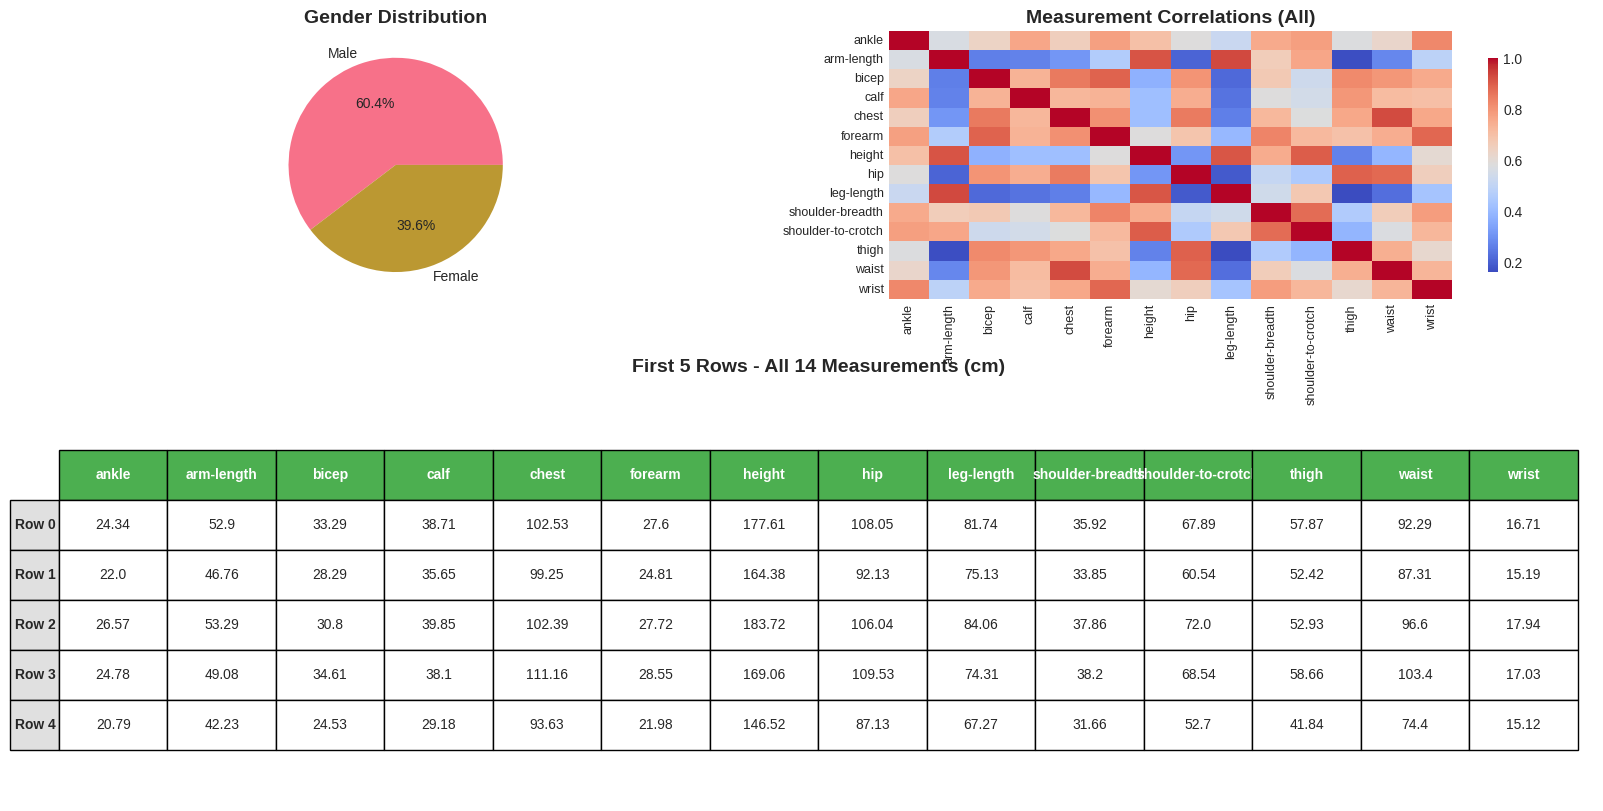

✅ Saved:  visualizations/dataset_overview.png


In [4]:
# PURPOSE: Create visualizations to understand dataset distribution and characteristics
# WHY: Important to know data balance, ranges, and correlations before training

# Create figure with custom layout
fig = plt.figure(figsize=(20, 10))

# Create grid:  2 rows, gender and correlation on top, table takes full bottom row
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1.5], hspace=0.3)

# PLOT 1: Gender distribution (pie chart)
# WHY: Check if dataset is balanced between male/female
ax1 = fig.add_subplot(gs[0, 0])
ax1.pie(metadata_df['gender']. value_counts(), labels=['Male', 'Female'], autopct='%1.1f%%')
ax1.set_title('Gender Distribution', fontsize=14, fontweight='bold')

# PLOT 2:  Correlation heatmap (ALL measurements)
# WHY: See which measurements are related (e.g., chest and shoulder width)
ax2 = fig.add_subplot(gs[0, 1])
corr = measurements_df[MEASUREMENT_COLUMNS]. corr()
sns.heatmap(corr, annot=False, ax=ax2, cmap='coolwarm', cbar_kws={'shrink': 0.8})
ax2.set_title('Measurement Correlations (All)', fontsize=14, fontweight='bold')
ax2.tick_params(axis='both', labelsize=9)

# PLOT 3: First 5 rows of dataset with ALL measurements
# WHY: Show actual data samples to understand dataset structure
ax3 = fig.add_subplot(gs[1, : ])  # Spans both columns
ax3.axis('off')

# Show all measurements for first 5 rows
sample_data = measurements_df[MEASUREMENT_COLUMNS].head(5)

# Create table with better formatting
table = ax3.table(
    cellText=sample_data.values. round(2),  # Round to 2 decimal places
    rowLabels=[f'Row {i}' for i in sample_data.index],
    colLabels=sample_data.columns,
    loc='center',
    cellLoc='center',
    colWidths=[0.07] * len(MEASUREMENT_COLUMNS)  # Equal width for all columns
)

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 3)

# Color header row
for i in range(len(MEASUREMENT_COLUMNS)):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Color row labels
for i in range(1, 6):
    table[(i, -1)].set_facecolor('#E0E0E0')
    table[(i, -1)].set_text_props(weight='bold')

ax3.set_title('First 5 Rows - All 14 Measurements (cm)', fontsize=14, fontweight='bold', pad=20)

# Save and display (removed tight_layout to avoid warning)
plt.savefig('visualizations/dataset_overview.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Saved:  visualizations/dataset_overview.png")

# Cell 5 - Data Augmentation Pipeline


In [5]:
# PURPOSE: Define image transformations for training and validation
# WHY: Augmentation helps model generalize better by creating variations of training images

def get_train_transforms():
    """
    Training augmentation pipeline
    WHY EACH TRANSFORMATION:
    - Resize: Standardize input size for model (512x384)
    - HorizontalFlip: People can face left or right (50% chance)
    - ShiftScaleRotate: Simulate camera angle variations (±15° rotation, 8% shift, 15% scale)
    - OneOf (Elastic/Grid/Optical): Simulate body shape variations and camera distortions
    - RandomBrightnessContrast: Handle different lighting conditions
    - HueSaturationValue: Handle color variations in clothing/skin tones
    - CoarseDropout: Random masking forces model to learn from partial information (regularization)
    - Normalize: Scale pixel values to match ImageNet pre-training (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    - ToTensorV2: Convert NumPy array → PyTorch tensor
    """
    return A. Compose([
        A.Resize(512, 384),  # Fixed size for model input
        A.HorizontalFlip(p=0.5),  # 50% chance to flip
        A.ShiftScaleRotate(shift_limit=0.08, scale_limit=0.15, rotate_limit=15, p=0.5),  # Geometric variations
        A.OneOf([  # Apply ONE of these transformations with 40% probability
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.3),  # Elastic deformation
            A.GridDistortion(p=0.3),  # Grid-based distortion
            A.OpticalDistortion(distort_limit=0.5, shift_limit=0.5, p=0.3)  # Lens distortion
        ], p=0.4),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),  # Lighting variations
        A.HueSaturationValue(hue_shift_limit=15, sat_shift_limit=25, val_shift_limit=15, p=0.3),  # Color variations
        A.CoarseDropout(max_holes=8, max_height=32, max_width=32, fill_value=0, p=0.3),  # Random black patches
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
        ToTensorV2()  # Convert to PyTorch tensor
    ])

def get_val_transforms():
    """
    Validation/Test augmentation pipeline
    WHY NO AUGMENTATION:  We want to evaluate on clean, unmodified images
    Only resize and normalize (same as training, but no random transformations)
    """
    return A.Compose([
        A.Resize(512, 384),  # Same size as training
        A. Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Same normalization as training
        ToTensorV2()
    ])

print("✅ Enhanced augmentation ready (better accuracy)")

✅ Enhanced augmentation ready (better accuracy)


# Cell 6 - Custom Dataset Class

In [6]:
# PURPOSE:  Define how to load images and measurements for PyTorch DataLoader
# WHY: PyTorch needs a Dataset class to efficiently load batches during training

class BodyMaskDataset(Dataset):
    """
    Custom PyTorch Dataset for body mask images and measurements

    WHAT IT DOES:
    1. Loads front and side body mask images from disk
    2. Applies augmentation (training) or just normalization (validation)
    3. Normalizes measurements using z-score normalization
    4. Returns a dictionary with images and target measurements
    """

    def __init__(self, data_df, data_dir, measurement_columns, transform=None,
                 target_mean=None, target_std=None):
        """
        Initialize dataset

        Args:
            data_df: DataFrame with photo_ids and measurements
            data_dir: Path to folder containing 'mask' and 'mask_left' folders
            measurement_columns:  List of measurement names (14 measurements)
            transform:  Augmentation pipeline (from Cell 5)
            target_mean: Mean of measurements (for normalization)
            target_std:  Std dev of measurements (for normalization)
        """
        self.data = data_df. reset_index(drop=True)
        self.data_dir = Path(data_dir)
        self.transform = transform
        self.measurements = measurement_columns

        # Calculate normalization statistics if not provided
        # WHY: Z-score normalization (x - mean) / std makes training more stable
        # Different measurements have different scales (chest:  ~90cm, arm: ~30cm)
        # Normalization puts them all on similar scale (~0 mean, ~1 std)
        if target_mean is None:
            measurements_array = np.array([[row[m] for m in measurement_columns]
                                          for _, row in data_df.iterrows()])
            self.target_mean = torch.FloatTensor(measurements_array. mean(axis=0))
            self.target_std = torch. FloatTensor(measurements_array.std(axis=0))
        else:
            # Use provided statistics (for validation/test sets)
            # WHY: Must use TRAINING set statistics for consistency
            self.target_mean = target_mean
            self.target_std = target_std

    def __len__(self):
        """Return number of samples in dataset"""
        return len(self.data)

    def __getitem__(self, idx):
        """
        Load one sample (called by DataLoader)

        Returns:
            Dictionary with:
            - 'front':  Front view image tensor [3, 512, 384]
            - 'side': Side view image tensor [3, 512, 384]
            - 'measurements': Normalized measurement tensor [14]
            - 'subject_id': Subject identifier (for debugging)
            - 'photo_id': Photo identifier (for debugging)
        """
        sample = self.data.iloc[idx]
        photo_id = sample['photo_id']

        # Construct file paths
        # WHY: Images stored in 'mask' (front) and 'mask_left' (side) folders
        # Try PNG first, fallback to JPG if not found
        front_path = self.data_dir / 'mask' / f'{photo_id}.png'
        if not front_path.exists():
            front_path = self.data_dir / 'mask' / f'{photo_id}.jpg'
        side_path = self. data_dir / 'mask_left' / f'{photo_id}.png'
        if not side_path.exists():
            side_path = self.data_dir / 'mask_left' / f'{photo_id}.jpg'

        # Load images as grayscale
        # WHY: Body masks are binary/grayscale (person vs background)
        front_img = cv2.imread(str(front_path), cv2.IMREAD_GRAYSCALE)
        side_img = cv2.imread(str(side_path), cv2.IMREAD_GRAYSCALE)

        # Handle missing images (create black image)
        # WHY:  Prevents crashes if file is missing
        if front_img is None or side_img is None:
            front_img = np.zeros((512, 384), dtype=np.uint8)
            side_img = np.zeros((512, 384), dtype=np.uint8)

        # Convert grayscale → RGB (3 channels)
        # WHY: Pre-trained models expect 3-channel input (RGB)
        front_img = cv2.cvtColor(front_img, cv2.COLOR_GRAY2RGB)
        side_img = cv2.cvtColor(side_img, cv2.COLOR_GRAY2RGB)

        # Apply augmentation/normalization
        if self.transform:
            front_img = self.transform(image=front_img)['image']
            side_img = self. transform(image=side_img)['image']

        # Get measurements and normalize
        # Formula: z = (x - mean) / std
        # WHY: Different measurements have different scales, normalization helps training
        measurements = torch.tensor([float(sample[m]) for m in self.measurements], dtype=torch.float32)
        measurements = (measurements - self.target_mean) / (self.target_std + 1e-8)  # 1e-8 prevents division by zero

        return {
            'front':  front_img,
            'side': side_img,
            'measurements': measurements,
            'subject_id': sample['subject_id'],
            'photo_id':  photo_id
        }

print("✅ Dataset class ready")

✅ Dataset class ready


# Cell 7 - Create Train/Val/Test Splits and DataLoaders

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-332835447.py:23: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.3),  # Elastic deformation
/tmp/ipython-input-332835447.py:25: UserWarning: Argument(s) 'shift_limit' are not valid for transform OpticalDistortion
  A.OpticalDistortion(distort_limit=0.5, shift_limit=0.5, p=0.3)  # Lens distortion
/tmp/ipython-input-332835447.py:29: UserWarning: Argument(s) 'max_holes, max_height, max_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=32, max_width=32, fill_value=0, p=0.3),  # Random black patches
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoade

✅ Datasets:  Train=4293, Val=920, Test=921
✅ Optimized Loaders:  Batch=16, Workers=4, Persistent=True
   Expected speedup: 2-3x faster per epoch


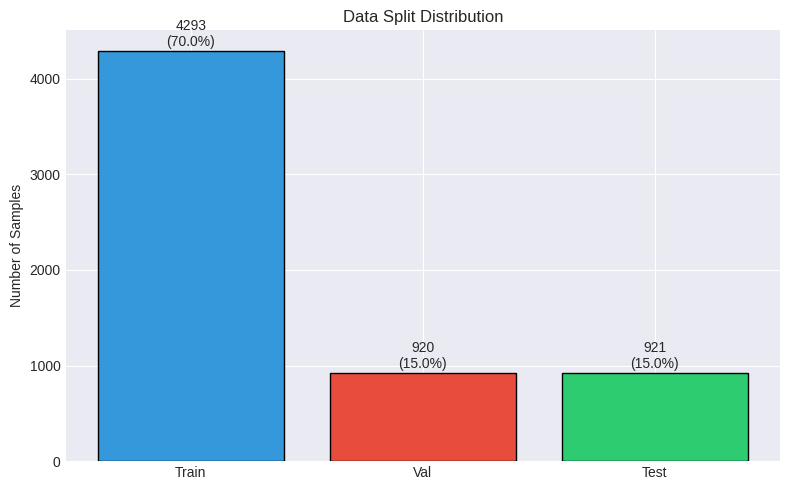

In [7]:
# PURPOSE: Split data into training, validation, and test sets, then create efficient data loaders
# WHY: Need separate sets for training (learn), validation (tune), and testing (final evaluation)

# STEP 1: Calculate split sizes
# 70% training, 15% validation, 15% test
# WHY: Standard split - training (most data for learning), validation (hyperparameter tuning), test (unbiased evaluation)
train_size = int(0.70 * len(data))
val_size = int(0.15 * len(data))

# STEP 2: Create shuffled indices
# WHY: Random shuffle ensures no ordering bias (e.g., all males first, then females)
indices = np.arange(len(data))
np.random.seed(42)  # Set seed for reproducibility
np.random.shuffle(indices)

# STEP 3: Split data using shuffled indices
train_data = data.iloc[indices[:train_size]].reset_index(drop=True)
val_data = data.iloc[indices[train_size: train_size+val_size]].reset_index(drop=True)
test_data = data.iloc[indices[train_size+val_size:]].reset_index(drop=True)

# STEP 4: Calculate normalization statistics FROM TRAINING DATA ONLY
# WHY CRITICAL: Must use ONLY training stats, not all data
# Using validation/test data would leak information and overestimate performance
train_measurements = np.array([[train_data. iloc[i][m] for m in MEASUREMENT_COLUMNS]
                               for i in range(len(train_data))])
target_mean = torch.FloatTensor(train_measurements.mean(axis=0))  # Mean per measurement
target_std = torch.FloatTensor(train_measurements. std(axis=0))    # Std per measurement

# STEP 5: Save normalization statistics
# WHY: Need these later for denormalization (convert predictions back to cm)
with open('results/normalization_stats.json', 'w') as f:
    json.dump({'target_mean': target_mean. tolist(), 'target_std': target_std.tolist(),
               'measurement_columns': MEASUREMENT_COLUMNS}, f)

# STEP 6: Create Dataset objects
# Training set: Uses augmentation (get_train_transforms)
# Validation/Test sets: No augmentation (get_val_transforms)
train_dataset = BodyMaskDataset(train_data, DRIVE_DATA_PATH, MEASUREMENT_COLUMNS,
                               get_train_transforms(), target_mean, target_std)
val_dataset = BodyMaskDataset(val_data, DRIVE_DATA_PATH, MEASUREMENT_COLUMNS,
                             get_val_transforms(), target_mean, target_std)
test_dataset = BodyMaskDataset(test_data, DRIVE_DATA_PATH, MEASUREMENT_COLUMNS,
                              get_val_transforms(), target_mean, target_std)

# STEP 7: Configure DataLoader settings
# WHY EACH PARAMETER:
BATCH_SIZE = 16       # Number of samples per batch (16 fits in GPU memory, larger = faster but needs more VRAM)
NUM_WORKERS = 4       # Parallel workers for data loading (4 = load 4 batches simultaneously)

# STEP 8: Create DataLoaders
# WHY DataLoader:  Efficiently loads batches, handles shuffling, parallel loading
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,              # Shuffle each epoch (prevents learning order patterns)
    num_workers=NUM_WORKERS,   # Parallel data loading
    pin_memory=True,           # Faster GPU transfer (copies to pinned memory)
    drop_last=True,            # Drop incomplete last batch (for batch norm stability)
    persistent_workers=True    # Keep workers alive between epochs (faster)
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,             # No shuffle for validation (order doesn't matter, but consistent)
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=True
)

print(f"✅ Datasets:  Train={len(train_dataset)}, Val={len(val_dataset)}, Test={len(test_dataset)}")
print(f"✅ Optimized Loaders:  Batch={BATCH_SIZE}, Workers={NUM_WORKERS}, Persistent=True")
print(f"   Expected speedup: 2-3x faster per epoch")

# STEP 9: Visualize data split
fig, ax = plt.subplots(figsize=(8, 5))
splits = ['Train', 'Val', 'Test']
counts = [len(train_data), len(val_data), len(test_data)]
colors = ['#3498db', '#e74c3c', '#2ecc71']
bars = ax.bar(splits, counts, color=colors, edgecolor='black')
ax.set_ylabel('Number of Samples')
ax.set_title('Data Split Distribution')
for bar, count in zip(bars, counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
           f'{count}\n({count/len(data)*100:.1f}%)', ha='center')
plt.tight_layout()
plt.savefig('visualizations/data_split.png', dpi=150)
plt.show()

# Cell 8 - Dual-Input Model Architecture

In [8]:
# PURPOSE: Define neural network that takes front+side images and predicts 14 measurements
# WHY:  Need a model that can process two views simultaneously for better 3D understanding

class DualInputBodyModel(nn.Module):
    """
    Dual-Input CNN for body measurement prediction

    ARCHITECTURE:
    1. Two separate encoders (one for front view, one for side view)
    2. Each encoder is a pre-trained CNN backbone (EfficientNet/ResNet/MobileNet)
    3. Features from both encoders are concatenated
    4. Regression head predicts 14 measurements from combined features

    WHY DUAL-INPUT:
    - Front view: Good for width measurements (chest, waist, hip)
    - Side view: Good for depth measurements and posture
    - Combined: Better 3D understanding of body shape
    """

    def __init__(self, backbone_name='efficientnet_b3', num_measurements=14, pretrained=True):
        """
        Initialize model

        Args:
            backbone_name: Which pre-trained model to use ('efficientnet_b3', 'resnet50', 'mobilenetv3_large_100')
            num_measurements:  Number of outputs (14 body measurements)
            pretrained: Use ImageNet pre-trained weights (True = better accuracy, starts from good features)
        """
        super().__init__()
        self.backbone_name = backbone_name
        self.num_measurements = num_measurements

        # STEP 1: Create two separate encoders (one for each view)
        # WHY timm library:  Provides state-of-the-art pre-trained models
        # WHY num_classes=0:  Remove classification head (we don't need ImageNet classes)
        # WHY global_pool='avg': Average pooling to get fixed-size feature vector
        self.front_encoder = timm.create_model(backbone_name, pretrained=pretrained, num_classes=0, global_pool='avg')
        self.side_encoder = timm.create_model(backbone_name, pretrained=pretrained, num_classes=0, global_pool='avg')

        # STEP 2: Determine feature dimension dynamically
        # WHY: Different backbones have different output sizes (EfficientNet: 1536, ResNet: 2048, etc.)
        with torch.no_grad():  # No gradients needed for this test
            feature_dim = self.front_encoder(torch.randn(1, 3, 512, 384)).shape[1]

        # STEP 3: Define regression head
        # INPUT:  Concatenated features from both encoders (feature_dim * 2)
        # OUTPUT: 14 measurements
        # WHY THIS ARCHITECTURE:
        # - Fully connected layers gradually reduce dimensionality (512 → 256 → 128 → 14)
        # - BatchNorm:  Stabilizes training by normalizing activations
        # - ReLU: Non-linear activation (allows learning complex patterns)
        # - Dropout: Regularization (randomly drops neurons to prevent overfitting)
        # - Higher dropout early (0.3), lower later (0.2) - standard practice
        self.regression_head = nn.Sequential(
            nn.Linear(feature_dim * 2, 512),  # Combine features → 512 neurons
            nn.BatchNorm1d(512),              # Normalize activations
            nn.ReLU(),                        # Non-linearity
            nn.Dropout(0.3),                  # 30% dropout (regularization)

            nn.Linear(512, 256),              # 512 → 256 neurons
            nn. BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),              # 256 → 128 neurons
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),                  # Lower dropout (20%)

            nn.Linear(128, num_measurements)  # Final layer:  128 → 14 measurements (NO activation - raw values)
        )

    def forward(self, front_img, side_img):
        """
        Forward pass:  Images → Measurements

        Args:
            front_img:  Tensor [batch_size, 3, 512, 384] - Front view images
            side_img: Tensor [batch_size, 3, 512, 384] - Side view images

        Returns:
            Tensor [batch_size, 14] - Predicted measurements (normalized)

        PROCESS:
        1. Pass front image through front encoder → front_features [batch_size, feature_dim]
        2. Pass side image through side encoder → side_features [batch_size, feature_dim]
        3. Concatenate features → combined [batch_size, feature_dim * 2]
        4. Pass through regression head → predictions [batch_size, 14]
        """
        front_features = self.front_encoder(front_img)  # Extract front view features
        side_features = self.side_encoder(side_img)     # Extract side view features
        combined = torch.cat([front_features, side_features], dim=1)  # Concatenate along feature dimension
        return self.regression_head(combined)           # Predict measurements

print("✅ Model architecture ready")

✅ Model architecture ready


# Cell 9 - Initialize Multiple Model Variants

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/22.1M [00:00<?, ?B/s]

✅ Initialized 3 models


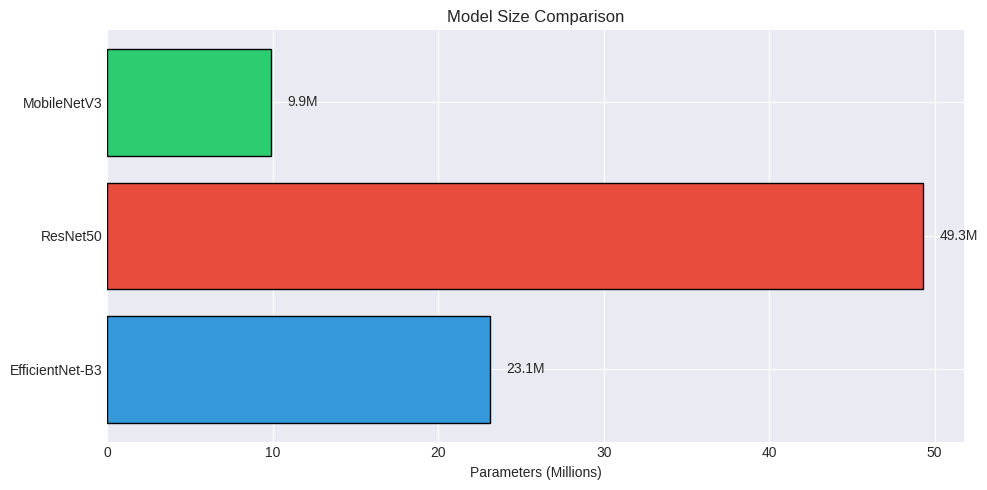

In [9]:
# PURPOSE: Create 3 different models (EfficientNet, ResNet, MobileNet) for comparison
# WHY: Different architectures have different strengths - we want to find the best one

# Define model configurations
# WHY THESE MODELS:
# - EfficientNet-B3: Best accuracy/efficiency balance, state-of-the-art for vision tasks
# - ResNet50: Classic architecture, very stable, widely used baseline
# - MobileNetV3: Fastest/lightest, good for mobile deployment
MODEL_CONFIGS = {
    'EfficientNet-B3': 'efficientnet_b3',      # ~12M parameters
    'ResNet50':  'resnet50',                    # ~25M parameters
    'MobileNetV3':  'mobilenetv3_large_100'     # ~5M parameters
}

# Initialize all models
models = {}
for name, backbone in MODEL_CONFIGS.items():
    # pretrained=True: Load ImageNet weights (much better starting point than random)
    # WHY: Pre-trained models already know basic visual features (edges, textures, shapes)
    #      This "transfer learning" dramatically improves accuracy and speeds up training
    models[name] = DualInputBodyModel(backbone, len(MEASUREMENT_COLUMNS), pretrained=True)

print(f"✅ Initialized {len(models)} models")

# Visualize model sizes (parameter count)
# WHY:  Helps understand model complexity and memory requirements
fig, ax = plt.subplots(figsize=(10, 5))
model_names = list(models.keys())
params = [sum(p.numel() for p in model.parameters())/1e6 for model in models.values()]  # Count parameters in millions
bars = ax.barh(model_names, params, color=['#3498db', '#e74c3c', '#2ecc71'], edgecolor='black')
ax.set_xlabel('Parameters (Millions)')
ax.set_title('Model Size Comparison')
for bar, param in zip(bars, params):
    ax.text(param + 1, bar.get_y() + bar.get_height()/2, f'{param:.1f}M', va='center')
plt.tight_layout()
plt.savefig('visualizations/model_sizes.png', dpi=150)
plt.show()

# Cell 10 - Optimized Trainer Class

In [10]:
# PURPOSE: Handle complete training pipeline with optimizations and metric tracking
# WHY:  Encapsulates training logic, mixed precision, learning rate scheduling, early stopping

from torch.cuda.amp import autocast, GradScaler

class Trainer:
    """
    Complete training pipeline for body measurement prediction

    FEATURES:
    1. Mixed Precision Training (2-3x speedup, 40% less memory)
    2. OneCycleLR scheduler (better than fixed LR)
    3. Early stopping (saves time by stopping when no improvement)
    4. Comprehensive metrics (MAE, RMSE, MAPE, R², threshold accuracy)
    5. Gradient clipping (prevents exploding gradients)
    """

    def __init__(self, model, train_loader, val_loader, model_name, device='cuda'):
        """
        Initialize trainer

        Args:
            model: DualInputBodyModel instance
            train_loader: DataLoader for training data
            val_loader: DataLoader for validation data
            model_name: Model name for logging (e.g., 'EfficientNet-B3')
            device:   'cuda' or 'cpu'
        """
        self.model = model. to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.model_name = model_name
        self.device = device
        self. epochs = 15  # Maximum number of epochs (may stop earlier with early stopping)

        # OPTIMIZER:  AdamW (Adam with weight decay)
        # WHY AdamW:  Better than SGD for computer vision, handles adaptive learning rates
        # lr=0.0001: Base learning rate (will be adjusted by scheduler)
        # weight_decay=0.0001: L2 regularization (prevents overfitting)
        self.optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0001)

        # LEARNING RATE SCHEDULER:  OneCycleLR
        # WHY OneCycleLR: Better than fixed LR or ReduceLROnPlateau
        # STRATEGY: Gradually increase LR (warmup), then decrease (annealing)
        # max_lr=0.001: Peak learning rate (10x base)
        # pct_start=0.3: First 30% is warmup, rest is annealing
        # anneal_strategy='cos': Cosine annealing (smooth decrease)
        self.scheduler = optim.lr_scheduler.OneCycleLR(
            self.optimizer,
            max_lr=0.001,
            epochs=self.epochs,
            steps_per_epoch=len(train_loader),
            pct_start=0.3,
            anneal_strategy='cos'
        )

        # LOSS FUNCTION: Mean Squared Error
        # WHY MSE: Standard for regression, penalizes large errors more (quadratic)
        self.criterion = nn.MSELoss()

        # MIXED PRECISION: GradScaler
        # WHY:  Uses float16 (half precision) for speed, float32 for stability
        # BENEFIT: 2-3x faster training, 40% less GPU memory
        self.scaler = GradScaler()

        # EARLY STOPPING: Stop training when validation performance plateaus
        # WHY:  Saves time, prevents overfitting
        # patience=5: Stop if no improvement for 5 consecutive epochs
        # min_delta=0.0001: Minimum improvement to count as "better"
        self.patience = 5
        self.min_delta = 0.0001
        self.counter = 0
        self.early_stop = False

        # Track best performance
        self.best_val_loss = float('inf')
        self.best_r2 = -float('inf')

        # History tracking (for plotting later)
        # Stores all metrics for every epoch
        self.history = {
            'train_loss': [], 'train_mae': [], 'train_rmse': [],
            'val_loss': [], 'val_mae': [], 'val_rmse': [],
            'val_mape': [], 'val_r2': [],
            'val_within_2cm': [], 'val_within_3cm': [],
            'epochs': []
        }

        # Load normalization statistics (saved in Cell 7)
        # WHY: Need to denormalize predictions back to cm for metric calculation
        with open('results/normalization_stats.json', 'r') as f:
            norm = json.load(f)
            self.target_mean = torch.FloatTensor(norm['target_mean']).to(device)
            self.target_std = torch.FloatTensor(norm['target_std']).to(device)

    def denormalize(self, normalized):
        """
        Convert normalized predictions back to real values (cm)

        Formula: x = z * std + mean
        (Inverse of normalization:  z = (x - mean) / std)

        WHY: Model outputs normalized values, we need cm for metrics
        """
        return normalized * self.target_std + self.target_mean

    def calculate_metrics(self, predictions, targets):
        """
        Calculate comprehensive accuracy metrics

        METRICS EXPLAINED:
        - MAE (Mean Absolute Error): Average error in cm (lower is better)
        - RMSE (Root Mean Squared Error): Like MAE but penalizes large errors more
        - MAPE (Mean Absolute Percentage Error): Error as percentage (good for relative comparison)
        - R² (R-squared): How well predictions match actual (1. 0 = perfect, 0 = baseline)
        - Within 2cm/3cm: Percentage of predictions within threshold (practical accuracy)

        Args:
            predictions:  Normalized predictions [batch_size, 14]
            targets: Normalized targets [batch_size, 14]

        Returns:
            Dictionary with all metrics
        """
        # Denormalize to real values (cm)
        pred_real = self.denormalize(predictions)
        target_real = self.denormalize(targets)

        # MAE:  Average absolute error
        mae = torch.mean(torch.abs(pred_real - target_real))

        # RMSE:  Root of mean squared error
        rmse = torch.sqrt(torch.mean((pred_real - target_real) ** 2))

        # MAPE: Mean absolute percentage error
        # +1e-8 prevents division by zero
        mape = torch.mean(torch.abs((pred_real - target_real) / (target_real + 1e-8))) * 100

        # R² Score:  Coefficient of determination
        # Formula: R² = 1 - (SS_residual / SS_total)
        # SS_residual:  Sum of squared residuals (prediction errors)
        # SS_total:  Total variance in data
        # R² = 1.0: Perfect predictions
        # R² = 0.0: Predictions as good as just using mean
        # R² < 0: Predictions worse than using mean
        ss_res = torch.sum((target_real - pred_real) ** 2)
        ss_tot = torch.sum((target_real - torch.mean(target_real)) ** 2)
        r2 = 1 - ss_res / (ss_tot + 1e-8)

        # Threshold accuracy:  Percentage of predictions within X cm
        # WHY: Practical metric - "How often are we within 2cm?"
        errors = torch.abs(pred_real - target_real)
        within_2cm = (errors <= 2.0).float().mean() * 100
        within_3cm = (errors <= 3.0).float().mean() * 100

        return {
            'mae': mae. item(),
            'rmse': rmse. item(),
            'mape': mape.item(),
            'r2': r2.item(),
            'within_2cm': within_2cm.item(),
            'within_3cm': within_3cm.item()
        }

    def train_epoch(self):
        """
        Train for one epoch (one pass through training data)

        PROCESS:
        1. Set model to training mode (enables dropout, batch norm training)
        2. Loop through batches
        3. Forward pass (predictions)
        4. Calculate loss
        5. Backward pass (gradients)
        6. Update weights
        7. Update learning rate (OneCycleLR updates per batch, not per epoch)

        Returns:
            Average loss and metrics for the epoch
        """
        self. model.train()  # Enable training mode
        all_outputs, all_targets = [], []
        total_loss, count = 0, 0

        # Progress bar for visualization
        pbar = tqdm(self.train_loader, desc=f'Training', leave=False)

        for batch in pbar:
            # Move data to GPU
            front = batch['front'].to(self. device)
            side = batch['side'].to(self.device)
            targets = batch['measurements'].to(self.device)

            # Zero gradients from previous iteration
            self.optimizer.zero_grad()

            # MIXED PRECISION: Forward pass in float16
            # WHY: Faster computation, less memory
            with autocast():
                outputs = self.model(front, side)
                loss = self.criterion(outputs, targets)

            # MIXED PRECISION: Backward pass with gradient scaling
            # WHY: Prevents gradient underflow in float16
            self.scaler.scale(loss).backward()

            # Unscale gradients before clipping
            self.scaler. unscale_(self.optimizer)

            # GRADIENT CLIPPING: Limit gradient magnitude to 1.0
            # WHY:  Prevents exploding gradients (sudden huge updates)
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)

            # Update weights
            self.scaler.step(self.optimizer)
            self.scaler.update()

            # UPDATE LEARNING RATE (OneCycleLR updates every batch)
            self.scheduler.step()

            # Track loss and predictions
            total_loss += loss. item()
            count += 1
            all_outputs.append(outputs.detach())
            all_targets. append(targets.detach())

            # Calculate batch metrics for progress bar
            with torch.no_grad():
                batch_metrics = self.calculate_metrics(outputs, targets)

            # Update progress bar
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'mae':  f'{batch_metrics["mae"]:.2f}cm',
                'r2': f'{batch_metrics["r2"]:.3f}',
                'lr': f'{self.optimizer.param_groups[0]["lr"]:.6f}'
            })

        # Calculate epoch-level metrics
        all_outputs = torch.cat(all_outputs, dim=0)
        all_targets = torch.cat(all_targets, dim=0)
        epoch_metrics = self.calculate_metrics(all_outputs, all_targets)

        return total_loss / count, epoch_metrics

    def validate(self):
        """
        Validate on validation set (no training, just evaluation)

        DIFFERENCES FROM TRAINING:
        1. model.eval() - Disables dropout, uses running stats for batch norm
        2. torch.no_grad() - No gradient computation (faster, less memory)
        3. No augmentation (handled by DataLoader with get_val_transforms)

        Returns:
            Average loss and metrics on validation set
        """
        self.model.eval()  # Evaluation mode
        all_outputs, all_targets = [], []
        total_loss, count = 0, 0

        # No gradients needed for validation
        with torch.no_grad():
            for batch in tqdm(self.val_loader, desc='Validating', leave=False):
                front = batch['front'].to(self.device)
                side = batch['side'].to(self.device)
                targets = batch['measurements'].to(self.device)

                # Mixed precision for inference (faster)
                with autocast():
                    outputs = self.model(front, side)
                    loss = self.criterion(outputs, targets)

                total_loss += loss.item()
                count += 1
                all_outputs.append(outputs)
                all_targets.append(targets)

        # Calculate validation metrics
        all_outputs = torch.cat(all_outputs, dim=0)
        all_targets = torch.cat(all_targets, dim=0)
        val_metrics = self.calculate_metrics(all_outputs, all_targets)

        return total_loss / count, val_metrics

    def train(self):
        """
        Main training loop - trains for multiple epochs with early stopping

        PROCESS:
        1. Loop through epochs
        2. Train one epoch
        3. Validate
        4. Check if performance improved (for early stopping)
        5. Save metrics
        6. Repeat until max epochs or early stopping

        Returns:
            History dictionary with all metrics
        """
        print(f"🚀 Starting optimized training:   {self.model_name}")
        print("="*90)

        for epoch in range(1, self.epochs + 1):
            # Check if early stopping triggered
            if self.early_stop:
                print(f"\n⚠️ Early stopping triggered at epoch {epoch-1}")
                break

            print(f"\n{'='*90}")
            print(f"Epoch {epoch}/{self.epochs} - {self.model_name}")
            print(f"{'='*90}")

            # Train and validate
            train_loss, train_metrics = self.train_epoch()
            val_loss, val_metrics = self.validate()

            # Store metrics in history
            self.history['epochs'].append(epoch)
            self.history['train_loss'].append(train_loss)
            self.history['train_mae'].append(train_metrics['mae'])
            self.history['train_rmse'].append(train_metrics['rmse'])
            self.history['val_loss'].append(val_loss)
            self.history['val_mae'].append(val_metrics['mae'])
            self.history['val_rmse'].append(val_metrics['rmse'])
            self.history['val_mape'].append(val_metrics['mape'])
            self.history['val_r2'].append(val_metrics['r2'])
            self.history['val_within_2cm'].append(val_metrics['within_2cm'])
            self.history['val_within_3cm'].append(val_metrics['within_3cm'])

            # Print metrics
            print(f"\n📊 Training Metrics:")
            print(f"   Loss: {train_loss:.4f} | MAE: {train_metrics['mae']:.2f}cm | "
                  f"RMSE: {train_metrics['rmse']:.2f}cm | R²: {train_metrics['r2']:.4f}")

            print(f"\n📊 Validation Metrics:")
            print(f"   Loss: {val_loss:.4f} | MAE: {val_metrics['mae']:.2f}cm | "
                  f"RMSE: {val_metrics['rmse']:.2f}cm")
            print(f"   MAPE: {val_metrics['mape']:.2f}% | R²: {val_metrics['r2']:.4f}")
            print(f"   Within 2cm: {val_metrics['within_2cm']:.1f}% | "
                  f"Within 3cm: {val_metrics['within_3cm']:.1f}%")

            # EARLY STOPPING CHECK
            # Use R² as primary metric (higher is better)
            # min_delta:  Must improve by at least this much
            if val_metrics['r2'] > self.best_r2 + self.min_delta:
                # Performance improved!
                self.best_r2 = val_metrics['r2']
                self.best_val_loss = val_loss
                self.counter = 0  # Reset counter
                print(f"\n   ✅ Best model so far! (R²:   {val_metrics['r2']:.4f}, MAE: {val_metrics['mae']:.2f}cm)")
            else:
                # No improvement
                self.counter += 1
                print(f"\n   ⏸️ No improvement for {self.counter}/{self.patience} epochs")
                if self. counter >= self.patience:
                    self.early_stop = True  # Trigger early stopping

            print(f"{'='*90}")

        # Print final summary
        print(f"\n{'🎉'*30}")
        print(f"Training Complete:   {self.model_name}")
        print(f"Stopped at epoch:   {len(self.history['epochs'])}/{self.epochs}")
        print(f"Best R² Score:  {self.best_r2:.4f}")
        print(f"Best Validation Loss: {self.best_val_loss:.4f}")
        print(f"Final MAE: {self.history['val_mae'][-1]:.2f}cm")
        print(f"Final Within 2cm: {self.history['val_within_2cm'][-1]:.1f}%")
        if self.early_stop:
            epochs_saved = self.epochs - len(self.history['epochs'])
            print(f"Time saved by early stopping: ~{epochs_saved * 100 // self.epochs}%")
        print(f"{'🎉'*30}\n")

        return self.history

print("✅ Optimized Trainer ready (Mixed Precision + OneCycleLR + Early Stopping + All Metrics)")

✅ Optimized Trainer ready (Mixed Precision + OneCycleLR + Early Stopping + All Metrics)


# Cell 11 - Train All Models

In [11]:
# PURPOSE: Train all 3 models (EfficientNet, ResNet, MobileNet)
# WHY: Compare different architectures to find best one

import gc
import torch

# Clear GPU memory before training
# WHY: Ensures maximum available memory for training
gc.collect()  # Python garbage collection
torch.cuda.empty_cache()  # Clear PyTorch's GPU cache

print(f"GPU Memory before training: {torch.cuda.memory_allocated()/1e9:.2f} GB\n")

# Dictionary to store training results
results = {}

# Train each model one by one
for model_name, model in models.items():
    print(f"\n{'🚀'*17}")
    print(f"{'🚀'*5} {model_name: ^15} {'🚀'*5}")
    print(f"{'🚀'*17}\n")

    # Clear memory before each model
    # WHY: Previous model may still be in memory
    gc.collect()
    torch.cuda.empty_cache()

    try:
        # Create trainer and train
        trainer = Trainer(model, train_loader, val_loader, model_name, device)
        results[model_name] = trainer.train()  # Returns history dictionary
        print(f"✅ {model_name} completed")
    except Exception as e:
        # Handle training failures gracefully
        # WHY: One model failing shouldn't stop others
        print(f"❌ {model_name} failed:   {e}")
        import traceback
        traceback.print_exc()
        results[model_name] = None  # Mark as failed

    # Clean up after each model
    # WHY:  Free GPU memory for next model
    if 'trainer' in locals():
        del trainer
    torch.cuda.empty_cache()

print("\n✅ ALL TRAINING COMPLETE")



GPU Memory before training: 0.00 GB


🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
🚀🚀🚀🚀🚀 EfficientNet-B3 🚀🚀🚀🚀🚀
🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀

🚀 Starting optimized training:   EfficientNet-B3

Epoch 1/15 - EfficientNet-B3


/tmp/ipython-input-1694570293.py:64: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler()


Training:   0%|          | 0/268 [00:00<?, ?it/s]

/tmp/ipython-input-1694570293.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Validating:   0%|          | 0/58 [00:00<?, ?it/s]

/tmp/ipython-input-1694570293.py:270: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



📊 Training Metrics:
   Loss: 0.9528 | MAE: 4.24cm | RMSE: 6.52cm | R²: 0.9756

📊 Validation Metrics:
   Loss: 0.5075 | MAE: 3.00cm | RMSE: 4.49cm
   MAPE: 4.84% | R²: 0.9884
   Within 2cm: 52.0% | Within 3cm: 65.8%

   ✅ Best model so far! (R²:   0.9884, MAE: 3.00cm)

Epoch 2/15 - EfficientNet-B3


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Validating:   0%|          | 0/58 [00:00<?, ?it/s]


📊 Training Metrics:
   Loss: 0.6203 | MAE: 3.37cm | RMSE: 5.06cm | R²: 0.9853

📊 Validation Metrics:
   Loss: 0.4376 | MAE: 2.77cm | RMSE: 4.07cm
   MAPE: 4.52% | R²: 0.9905
   Within 2cm: 54.3% | Within 3cm: 68.3%

   ✅ Best model so far! (R²:   0.9905, MAE: 2.77cm)

Epoch 3/15 - EfficientNet-B3


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Validating:   0%|          | 0/58 [00:00<?, ?it/s]


📊 Training Metrics:
   Loss: 0.5712 | MAE: 3.22cm | RMSE: 4.85cm | R²: 0.9865

📊 Validation Metrics:
   Loss: 0.4159 | MAE: 2.66cm | RMSE: 3.91cm
   MAPE: 4.36% | R²: 0.9912
   Within 2cm: 55.2% | Within 3cm: 69.2%

   ✅ Best model so far! (R²:   0.9912, MAE: 2.66cm)

Epoch 4/15 - EfficientNet-B3


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Validating:   0%|          | 0/58 [00:00<?, ?it/s]


📊 Training Metrics:
   Loss: 0.5422 | MAE: 3.14cm | RMSE: 4.72cm | R²: 0.9872

📊 Validation Metrics:
   Loss: 0.4305 | MAE: 2.77cm | RMSE: 4.07cm
   MAPE: 4.54% | R²: 0.9905
   Within 2cm: 54.3% | Within 3cm: 68.2%

   ⏸️ No improvement for 1/5 epochs

Epoch 5/15 - EfficientNet-B3


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Validating:   0%|          | 0/58 [00:00<?, ?it/s]


📊 Training Metrics:
   Loss: 0.5048 | MAE: 3.00cm | RMSE: 4.55cm | R²: 0.9881

📊 Validation Metrics:
   Loss: 0.3595 | MAE: 2.53cm | RMSE: 3.70cm
   MAPE: 4.14% | R²: 0.9921
   Within 2cm: 56.9% | Within 3cm: 71.7%

   ✅ Best model so far! (R²:   0.9921, MAE: 2.53cm)

Epoch 6/15 - EfficientNet-B3


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Validating:   0%|          | 0/58 [00:00<?, ?it/s]


📊 Training Metrics:
   Loss: 0.4575 | MAE: 2.86cm | RMSE: 4.28cm | R²: 0.9895

📊 Validation Metrics:
   Loss: 0.3739 | MAE: 2.59cm | RMSE: 3.85cm
   MAPE: 4.28% | R²: 0.9915
   Within 2cm: 56.3% | Within 3cm: 70.8%

   ⏸️ No improvement for 1/5 epochs

Epoch 7/15 - EfficientNet-B3


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Validating:   0%|          | 0/58 [00:00<?, ?it/s]


📊 Training Metrics:
   Loss: 0.4412 | MAE: 2.81cm | RMSE: 4.24cm | R²: 0.9897

📊 Validation Metrics:
   Loss: 0.3354 | MAE: 2.42cm | RMSE: 3.58cm
   MAPE: 3.91% | R²: 0.9926
   Within 2cm: 58.8% | Within 3cm: 72.6%

   ✅ Best model so far! (R²:   0.9926, MAE: 2.42cm)

Epoch 8/15 - EfficientNet-B3


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Validating:   0%|          | 0/58 [00:00<?, ?it/s]


📊 Training Metrics:
   Loss: 0.4111 | MAE: 2.72cm | RMSE: 4.06cm | R²: 0.9905

📊 Validation Metrics:
   Loss: 0.3246 | MAE: 2.38cm | RMSE: 3.53cm
   MAPE: 3.92% | R²: 0.9928
   Within 2cm: 59.6% | Within 3cm: 73.6%

   ✅ Best model so far! (R²:   0.9928, MAE: 2.38cm)

Epoch 9/15 - EfficientNet-B3


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Validating:   0%|          | 0/58 [00:00<?, ?it/s]


📊 Training Metrics:
   Loss: 0.3998 | MAE: 2.68cm | RMSE: 4.01cm | R²: 0.9908

📊 Validation Metrics:
   Loss: 0.3367 | MAE: 2.49cm | RMSE: 3.65cm
   MAPE: 4.09% | R²: 0.9924
   Within 2cm: 58.1% | Within 3cm: 71.9%

   ⏸️ No improvement for 1/5 epochs

Epoch 10/15 - EfficientNet-B3


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Validating:   0%|          | 0/58 [00:00<?, ?it/s]


📊 Training Metrics:
   Loss: 0.3717 | MAE: 2.59cm | RMSE: 3.87cm | R²: 0.9914

📊 Validation Metrics:
   Loss: 0.3138 | MAE: 2.37cm | RMSE: 3.51cm
   MAPE: 3.94% | R²: 0.9929
   Within 2cm: 60.1% | Within 3cm: 73.5%

   ⏸️ No improvement for 2/5 epochs

Epoch 11/15 - EfficientNet-B3


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Validating:   0%|          | 0/58 [00:00<?, ?it/s]


📊 Training Metrics:
   Loss: 0.3608 | MAE: 2.55cm | RMSE: 3.82cm | R²: 0.9916

📊 Validation Metrics:
   Loss: 0.2810 | MAE: 2.15cm | RMSE: 3.37cm
   MAPE: 3.57% | R²: 0.9935
   Within 2cm: 63.5% | Within 3cm: 76.8%

   ✅ Best model so far! (R²:   0.9935, MAE: 2.15cm)

Epoch 12/15 - EfficientNet-B3


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Validating:   0%|          | 0/58 [00:00<?, ?it/s]


📊 Training Metrics:
   Loss: 0.3319 | MAE: 2.44cm | RMSE: 3.63cm | R²: 0.9924

📊 Validation Metrics:
   Loss: 0.2617 | MAE: 2.09cm | RMSE: 3.23cm
   MAPE: 3.44% | R²: 0.9940
   Within 2cm: 64.5% | Within 3cm: 77.5%

   ✅ Best model so far! (R²:   0.9940, MAE: 2.09cm)

Epoch 13/15 - EfficientNet-B3


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Validating:   0%|          | 0/58 [00:00<?, ?it/s]


📊 Training Metrics:
   Loss: 0.3178 | MAE: 2.40cm | RMSE: 3.57cm | R²: 0.9927

📊 Validation Metrics:
   Loss: 0.2538 | MAE: 2.02cm | RMSE: 3.23cm
   MAPE: 3.32% | R²: 0.9940
   Within 2cm: 65.2% | Within 3cm: 78.6%

   ⏸️ No improvement for 1/5 epochs

Epoch 14/15 - EfficientNet-B3


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Validating:   0%|          | 0/58 [00:00<?, ?it/s]


📊 Training Metrics:
   Loss: 0.3028 | MAE: 2.34cm | RMSE: 3.48cm | R²: 0.9931

📊 Validation Metrics:
   Loss: 0.2448 | MAE: 1.98cm | RMSE: 3.14cm
   MAPE: 3.27% | R²: 0.9943
   Within 2cm: 66.2% | Within 3cm: 79.2%

   ✅ Best model so far! (R²:   0.9943, MAE: 1.98cm)

Epoch 15/15 - EfficientNet-B3


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Validating:   0%|          | 0/58 [00:00<?, ?it/s]


📊 Training Metrics:
   Loss: 0.3044 | MAE: 2.34cm | RMSE: 3.48cm | R²: 0.9930

📊 Validation Metrics:
   Loss: 0.2417 | MAE: 2.00cm | RMSE: 3.11cm
   MAPE: 3.29% | R²: 0.9944
   Within 2cm: 65.8% | Within 3cm: 79.0%

   ✅ Best model so far! (R²:   0.9944, MAE: 2.00cm)

🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉
Training Complete:   EfficientNet-B3
Stopped at epoch:   15/15
Best R² Score:  0.9944
Best Validation Loss: 0.2417
Final MAE: 2.00cm
Final Within 2cm: 65.8%
🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉

✅ EfficientNet-B3 completed

🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
🚀🚀🚀🚀🚀    ResNet50     🚀🚀🚀🚀🚀
🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀

🚀 Starting optimized training:   ResNet50

Epoch 1/15 - ResNet50


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Validating:   0%|          | 0/58 [00:00<?, ?it/s]


📊 Training Metrics:
   Loss: 1.1161 | MAE: 4.63cm | RMSE: 7.02cm | R²: 0.9717

📊 Validation Metrics:
   Loss: 1.1921 | MAE: 5.10cm | RMSE: 7.42cm
   MAPE: 8.60% | R²: 0.9683
   Within 2cm: 35.0% | Within 3cm: 47.3%

   ✅ Best model so far! (R²:   0.9683, MAE: 5.10cm)

Epoch 2/15 - ResNet50


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Validating:   0%|          | 0/58 [00:00<?, ?it/s]


📊 Training Metrics:
   Loss: 0.7197 | MAE: 3.68cm | RMSE: 5.55cm | R²: 0.9823

📊 Validation Metrics:
   Loss: 0.6326 | MAE: 3.43cm | RMSE: 5.09cm
   MAPE: 5.60% | R²: 0.9851
   Within 2cm: 46.6% | Within 3cm: 61.1%

   ✅ Best model so far! (R²:   0.9851, MAE: 3.43cm)

Epoch 3/15 - ResNet50


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Validating:   0%|          | 0/58 [00:00<?, ?it/s]


📊 Training Metrics:
   Loss: 0.5978 | MAE: 3.29cm | RMSE: 4.96cm | R²: 0.9859

📊 Validation Metrics:
   Loss: 0.5291 | MAE: 3.05cm | RMSE: 4.55cm
   MAPE: 5.04% | R²: 0.9881
   Within 2cm: 50.4% | Within 3cm: 65.2%

   ✅ Best model so far! (R²:   0.9881, MAE: 3.05cm)

Epoch 4/15 - ResNet50


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Validating:   0%|          | 0/58 [00:00<?, ?it/s]


📊 Training Metrics:
   Loss: 0.5478 | MAE: 3.13cm | RMSE: 4.72cm | R²: 0.9872

📊 Validation Metrics:
   Loss: 0.5168 | MAE: 3.07cm | RMSE: 4.51cm
   MAPE: 5.04% | R²: 0.9883
   Within 2cm: 50.5% | Within 3cm: 64.6%

   ✅ Best model so far! (R²:   0.9883, MAE: 3.07cm)

Epoch 5/15 - ResNet50


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Validating:   0%|          | 0/58 [00:00<?, ?it/s]


📊 Training Metrics:
   Loss: 0.4996 | MAE: 2.98cm | RMSE: 4.48cm | R²: 0.9885

📊 Validation Metrics:
   Loss: 0.3901 | MAE: 2.66cm | RMSE: 3.83cm
   MAPE: 4.46% | R²: 0.9916
   Within 2cm: 54.7% | Within 3cm: 69.5%

   ✅ Best model so far! (R²:   0.9916, MAE: 2.66cm)

Epoch 6/15 - ResNet50


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Validating:   0%|          | 0/58 [00:00<?, ?it/s]


📊 Training Metrics:
   Loss: 0.4664 | MAE: 2.88cm | RMSE: 4.33cm | R²: 0.9893

📊 Validation Metrics:
   Loss: 0.3864 | MAE: 2.57cm | RMSE: 3.67cm
   MAPE: 4.37% | R²: 0.9923
   Within 2cm: 55.3% | Within 3cm: 70.5%

   ✅ Best model so far! (R²:   0.9923, MAE: 2.57cm)

Epoch 7/15 - ResNet50


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Validating:   0%|          | 0/58 [00:00<?, ?it/s]


📊 Training Metrics:
   Loss: 0.4422 | MAE: 2.81cm | RMSE: 4.22cm | R²: 0.9898

📊 Validation Metrics:
   Loss: 0.3475 | MAE: 2.42cm | RMSE: 3.58cm
   MAPE: 4.03% | R²: 0.9926
   Within 2cm: 58.4% | Within 3cm: 72.8%

   ✅ Best model so far! (R²:   0.9926, MAE: 2.42cm)

Epoch 8/15 - ResNet50


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Validating:   0%|          | 0/58 [00:00<?, ?it/s]


📊 Training Metrics:
   Loss: 0.4229 | MAE: 2.76cm | RMSE: 4.14cm | R²: 0.9902

📊 Validation Metrics:
   Loss: 0.3418 | MAE: 2.43cm | RMSE: 3.55cm
   MAPE: 4.09% | R²: 0.9928
   Within 2cm: 58.2% | Within 3cm: 72.3%

   ✅ Best model so far! (R²:   0.9928, MAE: 2.43cm)

Epoch 9/15 - ResNet50


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Validating:   0%|          | 0/58 [00:00<?, ?it/s]


📊 Training Metrics:
   Loss: 0.3919 | MAE: 2.66cm | RMSE: 3.96cm | R²: 0.9910

📊 Validation Metrics:
   Loss: 0.3502 | MAE: 2.40cm | RMSE: 3.62cm
   MAPE: 3.87% | R²: 0.9925
   Within 2cm: 59.5% | Within 3cm: 73.9%

   ⏸️ No improvement for 1/5 epochs

Epoch 10/15 - ResNet50


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Validating:   0%|          | 0/58 [00:00<?, ?it/s]


📊 Training Metrics:
   Loss: 0.3775 | MAE: 2.58cm | RMSE: 3.86cm | R²: 0.9915

📊 Validation Metrics:
   Loss: 0.2767 | MAE: 2.17cm | RMSE: 3.20cm
   MAPE: 3.55% | R²: 0.9941
   Within 2cm: 63.1% | Within 3cm: 75.8%

   ✅ Best model so far! (R²:   0.9941, MAE: 2.17cm)

Epoch 11/15 - ResNet50


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Validating:   0%|          | 0/58 [00:00<?, ?it/s]


📊 Training Metrics:
   Loss: 0.3626 | MAE: 2.56cm | RMSE: 3.81cm | R²: 0.9917

📊 Validation Metrics:
   Loss: 0.2880 | MAE: 2.27cm | RMSE: 3.31cm
   MAPE: 3.79% | R²: 0.9937
   Within 2cm: 60.8% | Within 3cm: 74.5%

   ⏸️ No improvement for 1/5 epochs

Epoch 12/15 - ResNet50


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Validating:   0%|          | 0/58 [00:00<?, ?it/s]


📊 Training Metrics:
   Loss: 0.3282 | MAE: 2.43cm | RMSE: 3.60cm | R²: 0.9925

📊 Validation Metrics:
   Loss: 0.2425 | MAE: 2.02cm | RMSE: 3.00cm
   MAPE: 3.33% | R²: 0.9948
   Within 2cm: 65.3% | Within 3cm: 78.2%

   ✅ Best model so far! (R²:   0.9948, MAE: 2.02cm)

Epoch 13/15 - ResNet50


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Validating:   0%|          | 0/58 [00:00<?, ?it/s]


📊 Training Metrics:
   Loss: 0.3227 | MAE: 2.40cm | RMSE: 3.59cm | R²: 0.9926

📊 Validation Metrics:
   Loss: 0.2396 | MAE: 2.02cm | RMSE: 3.02cm
   MAPE: 3.34% | R²: 0.9948
   Within 2cm: 65.6% | Within 3cm: 78.4%

   ⏸️ No improvement for 1/5 epochs

Epoch 14/15 - ResNet50


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Validating:   0%|          | 0/58 [00:00<?, ?it/s]


📊 Training Metrics:
   Loss: 0.3056 | MAE: 2.32cm | RMSE: 3.47cm | R²: 0.9931

📊 Validation Metrics:
   Loss: 0.2265 | MAE: 1.96cm | RMSE: 2.91cm
   MAPE: 3.23% | R²: 0.9951
   Within 2cm: 66.4% | Within 3cm: 79.3%

   ✅ Best model so far! (R²:   0.9951, MAE: 1.96cm)

Epoch 15/15 - ResNet50


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Validating:   0%|          | 0/58 [00:00<?, ?it/s]


📊 Training Metrics:
   Loss: 0.3099 | MAE: 2.36cm | RMSE: 3.53cm | R²: 0.9928

📊 Validation Metrics:
   Loss: 0.2271 | MAE: 1.96cm | RMSE: 2.92cm
   MAPE: 3.25% | R²: 0.9951
   Within 2cm: 66.3% | Within 3cm: 79.1%

   ⏸️ No improvement for 1/5 epochs

🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉
Training Complete:   ResNet50
Stopped at epoch:   15/15
Best R² Score:  0.9951
Best Validation Loss: 0.2265
Final MAE: 1.96cm
Final Within 2cm: 66.3%
🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉

✅ ResNet50 completed

🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
🚀🚀🚀🚀🚀   MobileNetV3   🚀🚀🚀🚀🚀
🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀

🚀 Starting optimized training:   MobileNetV3

Epoch 1/15 - MobileNetV3


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Validating:   0%|          | 0/58 [00:00<?, ?it/s]


📊 Training Metrics:
   Loss: 1.0451 | MAE: 4.45cm | RMSE: 6.75cm | R²: 0.9739

📊 Validation Metrics:
   Loss: 0.6276 | MAE: 3.39cm | RMSE: 4.95cm
   MAPE: 5.55% | R²: 0.9859
   Within 2cm: 46.0% | Within 3cm: 60.6%

   ✅ Best model so far! (R²:   0.9859, MAE: 3.39cm)

Epoch 2/15 - MobileNetV3


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Validating:   0%|          | 0/58 [00:00<?, ?it/s]


📊 Training Metrics:
   Loss: 0.6588 | MAE: 3.48cm | RMSE: 5.22cm | R²: 0.9843

📊 Validation Metrics:
   Loss: 0.4494 | MAE: 2.84cm | RMSE: 4.24cm
   MAPE: 4.61% | R²: 0.9897
   Within 2cm: 54.1% | Within 3cm: 67.9%

   ✅ Best model so far! (R²:   0.9897, MAE: 2.84cm)

Epoch 3/15 - MobileNetV3


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Validating:   0%|          | 0/58 [00:00<?, ?it/s]


📊 Training Metrics:
   Loss: 0.5894 | MAE: 3.26cm | RMSE: 4.91cm | R²: 0.9861

📊 Validation Metrics:
   Loss: 0.5239 | MAE: 3.14cm | RMSE: 4.76cm
   MAPE: 4.93% | R²: 0.9870
   Within 2cm: 51.8% | Within 3cm: 65.3%

   ⏸️ No improvement for 1/5 epochs

Epoch 4/15 - MobileNetV3


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Validating:   0%|          | 0/58 [00:00<?, ?it/s]


📊 Training Metrics:
   Loss: 0.5542 | MAE: 3.15cm | RMSE: 4.76cm | R²: 0.9870

📊 Validation Metrics:
   Loss: 0.4077 | MAE: 2.64cm | RMSE: 3.85cm
   MAPE: 4.37% | R²: 0.9915
   Within 2cm: 55.2% | Within 3cm: 69.7%

   ✅ Best model so far! (R²:   0.9915, MAE: 2.64cm)

Epoch 5/15 - MobileNetV3


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Validating:   0%|          | 0/58 [00:00<?, ?it/s]


📊 Training Metrics:
   Loss: 0.5106 | MAE: 3.01cm | RMSE: 4.55cm | R²: 0.9881

📊 Validation Metrics:
   Loss: 0.4057 | MAE: 2.71cm | RMSE: 4.03cm
   MAPE: 4.37% | R²: 0.9906
   Within 2cm: 55.7% | Within 3cm: 69.0%

   ⏸️ No improvement for 1/5 epochs

Epoch 6/15 - MobileNetV3


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Validating:   0%|          | 0/58 [00:00<?, ?it/s]


📊 Training Metrics:
   Loss: 0.4762 | MAE: 2.92cm | RMSE: 4.39cm | R²: 0.9889

📊 Validation Metrics:
   Loss: 0.4702 | MAE: 2.77cm | RMSE: 4.09cm
   MAPE: 4.56% | R²: 0.9904
   Within 2cm: 53.1% | Within 3cm: 67.9%

   ⏸️ No improvement for 2/5 epochs

Epoch 7/15 - MobileNetV3


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Validating:   0%|          | 0/58 [00:00<?, ?it/s]


📊 Training Metrics:
   Loss: 0.4642 | MAE: 2.86cm | RMSE: 4.29cm | R²: 0.9895

📊 Validation Metrics:
   Loss: 0.3717 | MAE: 2.56cm | RMSE: 3.78cm
   MAPE: 4.21% | R²: 0.9918
   Within 2cm: 57.0% | Within 3cm: 70.8%

   ✅ Best model so far! (R²:   0.9918, MAE: 2.56cm)

Epoch 8/15 - MobileNetV3


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Validating:   0%|          | 0/58 [00:00<?, ?it/s]


📊 Training Metrics:
   Loss: 0.4377 | MAE: 2.79cm | RMSE: 4.19cm | R²: 0.9899

📊 Validation Metrics:
   Loss: 0.3318 | MAE: 2.38cm | RMSE: 3.53cm
   MAPE: 3.84% | R²: 0.9928
   Within 2cm: 59.6% | Within 3cm: 72.8%

   ✅ Best model so far! (R²:   0.9928, MAE: 2.38cm)

Epoch 9/15 - MobileNetV3


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Validating:   0%|          | 0/58 [00:00<?, ?it/s]


📊 Training Metrics:
   Loss: 0.4126 | MAE: 2.71cm | RMSE: 4.05cm | R²: 0.9906

📊 Validation Metrics:
   Loss: 0.3382 | MAE: 2.40cm | RMSE: 3.54cm
   MAPE: 3.94% | R²: 0.9928
   Within 2cm: 59.2% | Within 3cm: 72.5%

   ⏸️ No improvement for 1/5 epochs

Epoch 10/15 - MobileNetV3


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Validating:   0%|          | 0/58 [00:00<?, ?it/s]


📊 Training Metrics:
   Loss: 0.4000 | MAE: 2.67cm | RMSE: 3.98cm | R²: 0.9909

📊 Validation Metrics:
   Loss: 0.3076 | MAE: 2.31cm | RMSE: 3.38cm
   MAPE: 3.82% | R²: 0.9935
   Within 2cm: 60.5% | Within 3cm: 74.1%

   ✅ Best model so far! (R²:   0.9935, MAE: 2.31cm)

Epoch 11/15 - MobileNetV3


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Validating:   0%|          | 0/58 [00:00<?, ?it/s]


📊 Training Metrics:
   Loss: 0.3749 | MAE: 2.58cm | RMSE: 3.87cm | R²: 0.9914

📊 Validation Metrics:
   Loss: 0.2914 | MAE: 2.25cm | RMSE: 3.30cm
   MAPE: 3.71% | R²: 0.9937
   Within 2cm: 61.5% | Within 3cm: 75.2%

   ✅ Best model so far! (R²:   0.9937, MAE: 2.25cm)

Epoch 12/15 - MobileNetV3


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Validating:   0%|          | 0/58 [00:00<?, ?it/s]


📊 Training Metrics:
   Loss: 0.3600 | MAE: 2.52cm | RMSE: 3.75cm | R²: 0.9919

📊 Validation Metrics:
   Loss: 0.2785 | MAE: 2.17cm | RMSE: 3.27cm
   MAPE: 3.55% | R²: 0.9939
   Within 2cm: 62.8% | Within 3cm: 76.5%

   ✅ Best model so far! (R²:   0.9939, MAE: 2.17cm)

Epoch 13/15 - MobileNetV3


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Validating:   0%|          | 0/58 [00:00<?, ?it/s]


📊 Training Metrics:
   Loss: 0.3371 | MAE: 2.46cm | RMSE: 3.67cm | R²: 0.9923

📊 Validation Metrics:
   Loss: 0.2681 | MAE: 2.11cm | RMSE: 3.20cm
   MAPE: 3.46% | R²: 0.9941
   Within 2cm: 64.0% | Within 3cm: 77.1%

   ✅ Best model so far! (R²:   0.9941, MAE: 2.11cm)

Epoch 14/15 - MobileNetV3


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Validating:   0%|          | 0/58 [00:00<?, ?it/s]


📊 Training Metrics:
   Loss: 0.3391 | MAE: 2.46cm | RMSE: 3.66cm | R²: 0.9923

📊 Validation Metrics:
   Loss: 0.2743 | MAE: 2.12cm | RMSE: 3.26cm
   MAPE: 3.51% | R²: 0.9939
   Within 2cm: 64.1% | Within 3cm: 77.2%

   ⏸️ No improvement for 1/5 epochs

Epoch 15/15 - MobileNetV3


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Validating:   0%|          | 0/58 [00:00<?, ?it/s]


📊 Training Metrics:
   Loss: 0.3281 | MAE: 2.41cm | RMSE: 3.58cm | R²: 0.9927

📊 Validation Metrics:
   Loss: 0.2663 | MAE: 2.10cm | RMSE: 3.19cm
   MAPE: 3.47% | R²: 0.9942
   Within 2cm: 64.3% | Within 3cm: 77.5%

   ⏸️ No improvement for 2/5 epochs

🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉
Training Complete:   MobileNetV3
Stopped at epoch:   15/15
Best R² Score:  0.9941
Best Validation Loss: 0.2681
Final MAE: 2.10cm
Final Within 2cm: 64.3%
🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉

✅ MobileNetV3 completed

✅ ALL TRAINING COMPLETE
